# Combining Grid Search and Halving Grid Search for Model Optimization
<br> <br>
One may wonders what kind of pre-processing technique should apply that can generate best result? Such as:
* ordinal encoding or one-hot-encode
* standardisation or normalisation <br>

Meanwhile taking care of model parameters is adding another layer of difficulty.

This notebooks has show case how a nested grid search work to tune the preprocessing technique and as well models'parameters. It combines grid search and Halving grid search technique for optimisation.

After evaluating 3 regressors, Random Forest Regressor is the best model due to the best MAR, MSE, RMSE, R2 and Adj-R2.

Notebook Author: Morris Lee <br>
Date: 27-8-2022

#### [Preprocessing Part](#0.11)  
* [Import Packages and Define Useful Functions](#0.1)

#### [Visualisation](#0.21)  
* [Plot Pairwise Relationships](#0.2)
* [Plot Target Distribution](#0.3)
* [Plot Bar of Pie](#0.4)  

#### [Modelling Part](#0.51)  
* [Showcase of Preprocessors Param Grid Search](#0.5)
* [Define Nested Grid Search Algorithm](#0.6)
* [Nested Optimisation Search for KNeighborsRegressor ](#0.7)
* [Nested Optimisation Search for DecisionTreeRegressors](#0.8)
* [Nested Optimisation Search for Random Forest Regressors](#0.9)
* [Concatenate Results](#1.0)
* [Best Model Summary](#1.1)


# Preprocessing Part  <a class="anchor" id="0.11"></a>

# Import Packages and Define Useful Functions <a class="anchor" id="0.1"></a>

Let us import packages and define useful functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns
import scipy as sp
from tqdm import tqdm

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

def trim(df):
    df.columns = df.columns.str.strip()
    df = df.drop_duplicates()
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(' ','_')
    df_obj = df.select_dtypes(['object'])
    df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
    print("All column names have been striped, lowered case, replaced space with underscore if any")
    print("Dropped duplicated instances if any")
    print("Categorical instances have been striped")
    return df
def shape(df,df_name):
    print(f'STATUS: Dimension of "{df_name}" = {df.shape}')

def vc(df, column, r=False):
    vc_df = df.reset_index().groupby([column]).size().to_frame('count')
    vc_df['percentage (%)'] = vc_df['count'].div(sum(vc_df['count'])).mul(100)
    vc_df = vc_df.sort_values(by=['percentage (%)'], ascending=False)
    print(f'STATUS: Value counts of "{column}"...')
    display(vc_df)
    if r:
        return vc_df

df = pd.read_csv("/kaggle/input/price-prediction-multiple-linear-regression/scrap price.csv")
shape(df,'df')
df = trim(df)
display(df.head())
df.drop(['id','name'],axis=1,inplace=True)

shape(df,'df - after drop 2 col')
display(df.head())
df.info()

STATUS: Dimension of "df" = (205, 26)
All column names have been striped, lowered case, replaced space with underscore if any
Dropped duplicated instances if any
Categorical instances have been striped


,id,symboling,name,fueltypes,aspiration,doornumbers,carbody,drivewheels,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


STATUS: Dimension of "df - after drop 2 col" = (205, 24)


,symboling,fueltypes,aspiration,doornumbers,carbody,drivewheels,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,3,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,1,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,2,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,2,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 205 entries, 0 to 204
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   symboling         205 non-null    int64  
 1   fueltypes         205 non-null    object 
 2   aspiration        205 non-null    object 
 3   doornumbers       205 non-null    object 
 4   carbody           205 non-null    object 
 5   drivewheels       205 non-null    object 
 6   enginelocation    205 non-null    object 
 7   wheelbase         205 non-null    float64
 8   carlength         205 non-null    float64
 9   carwidth          205 non-null    float64
 10  carheight         205 non-null    float64
 11  curbweight        205 non-null    int64  
 12  enginetype        205 non-null    object 
 13  cylindernumber    205 non-null    object 
 14  enginesize        205 non-null    int64  
 15  fuelsystem        205 non-null    object 
 16  boreratio         205 non-null    float64
 1

# Visualisation <a class="anchor" id="0.21"></a>

# Plot Pairwise Relationships <a class="anchor" id="0.2"></a>

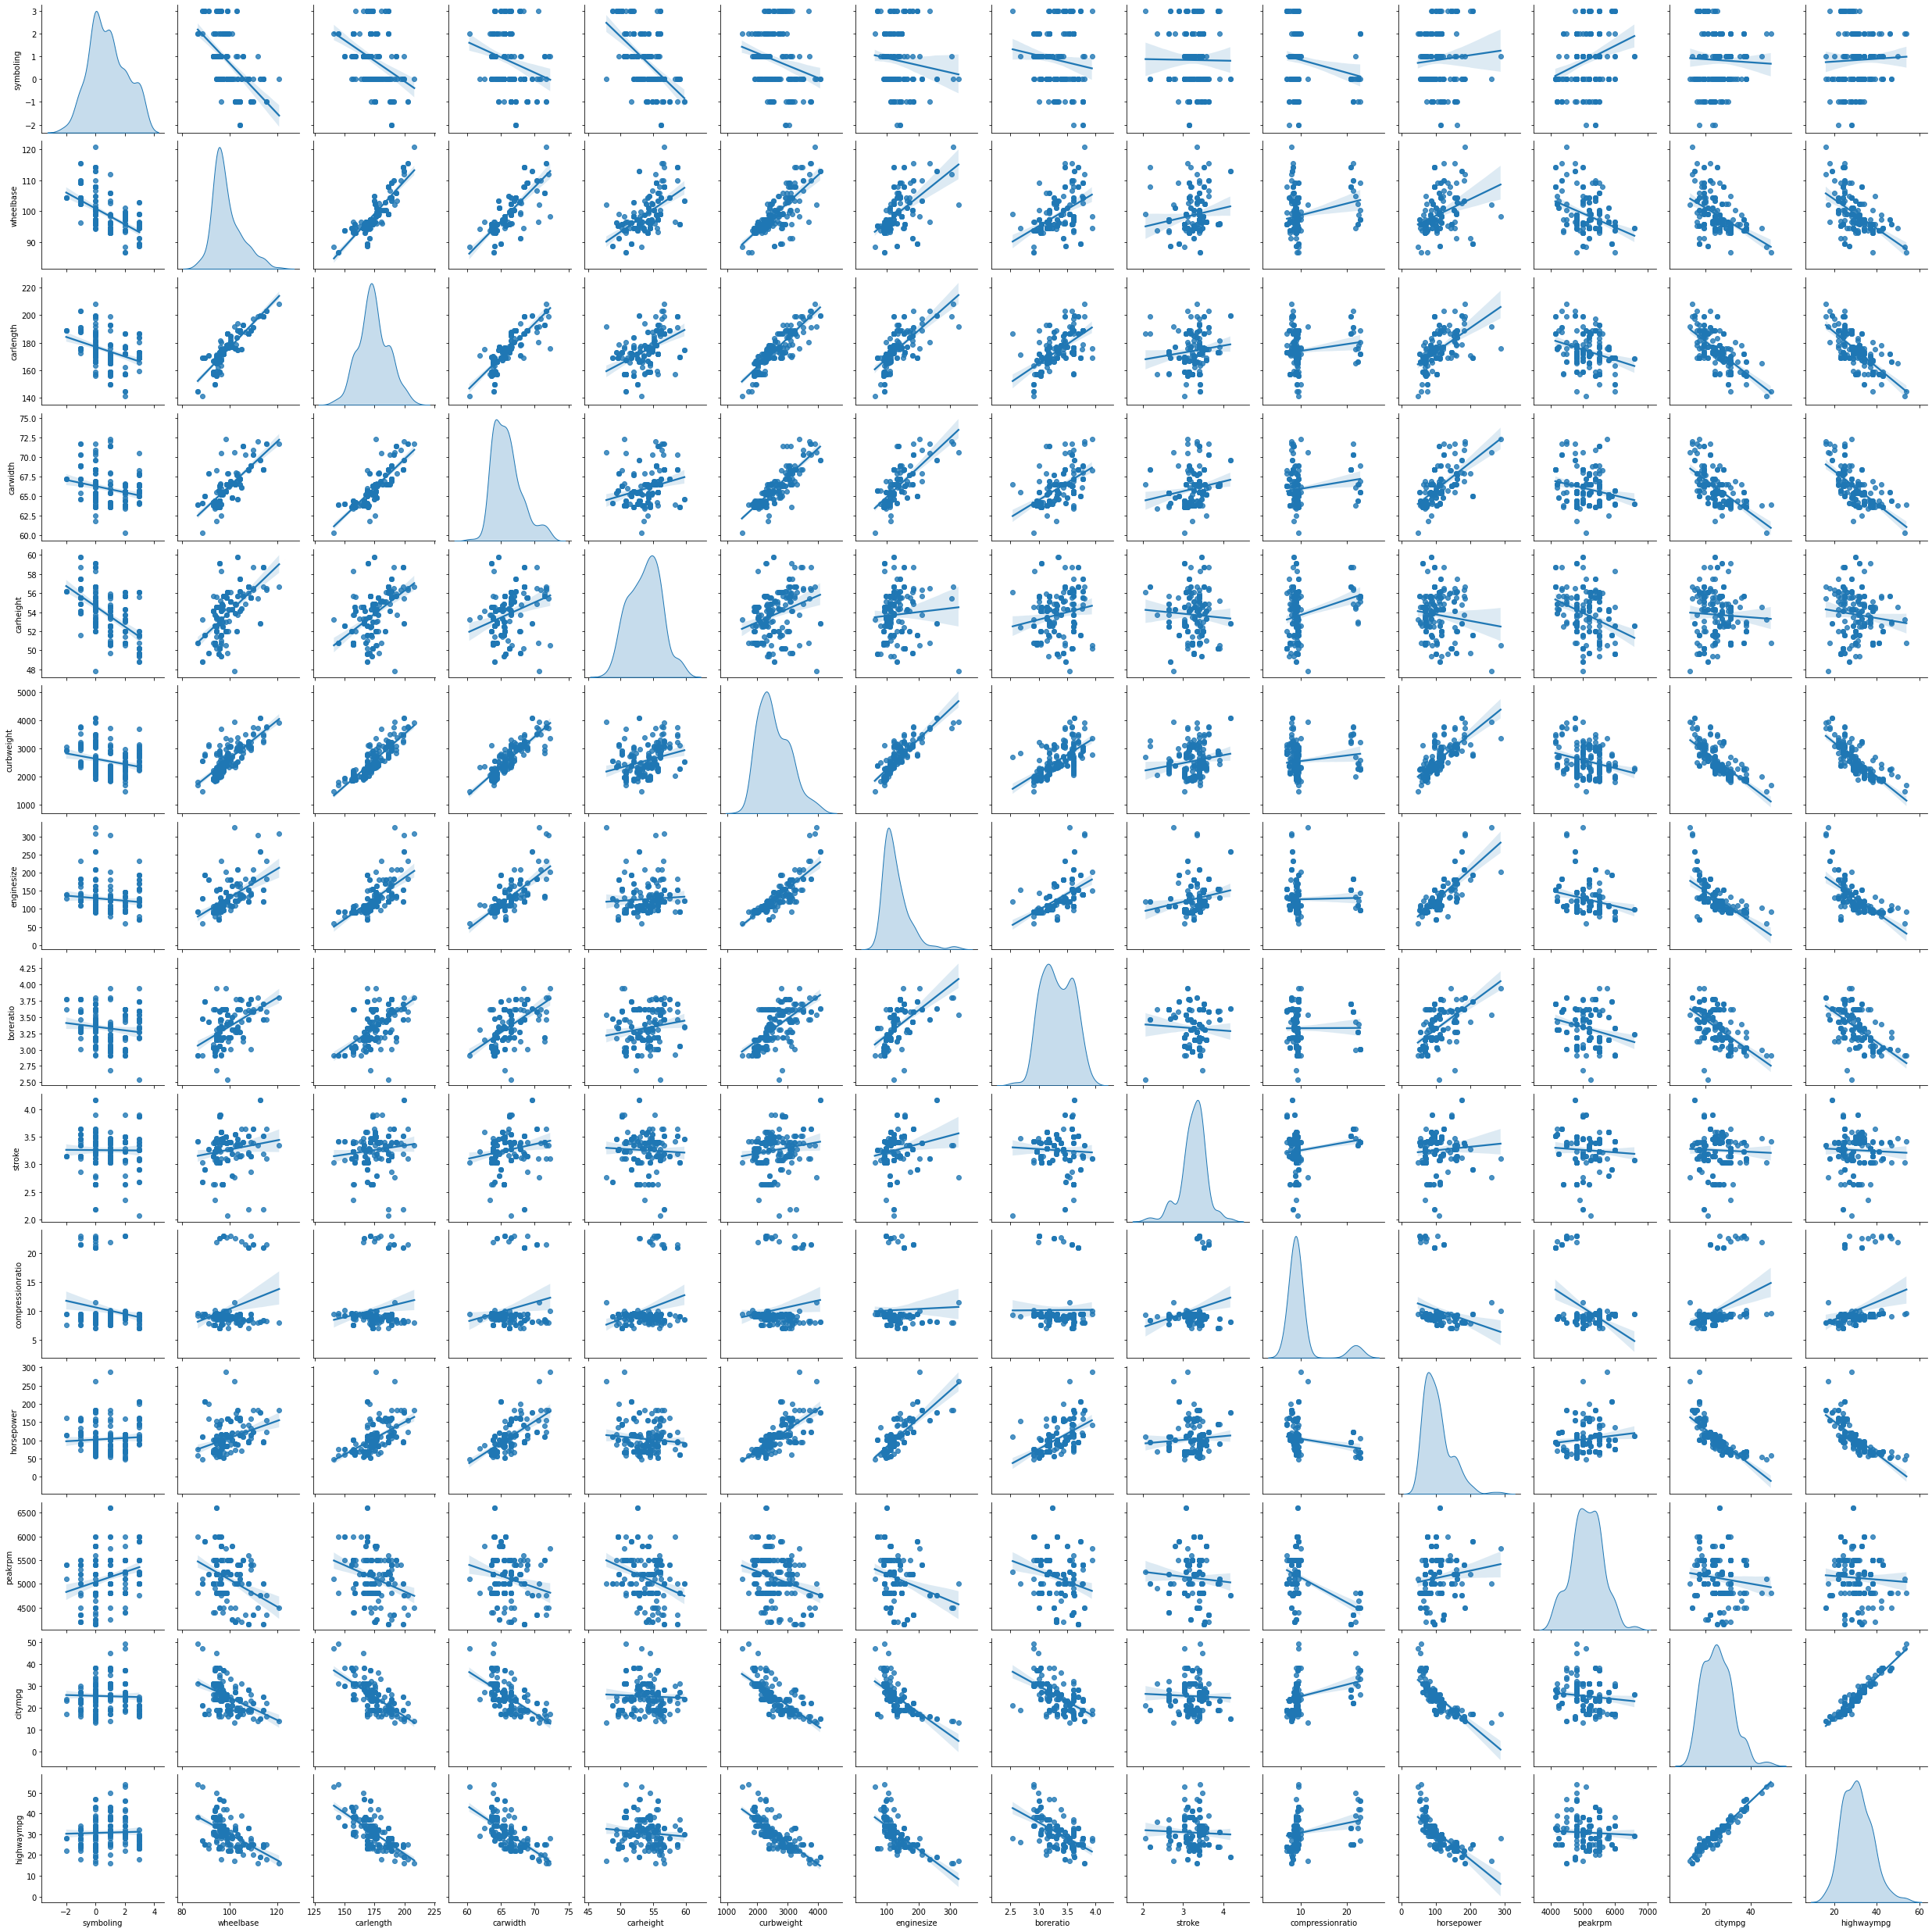

In [2]:
X = df.drop('price', axis=1)
y = df.price.values
_ = sns.pairplot(X, kind="reg", diag_kind="kde")

# Plot Target Distribution <a class="anchor" id="0.3"></a>

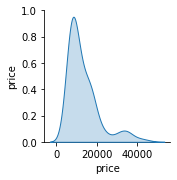

In [3]:
_ = sns.pairplot(df[['price']], kind="reg", diag_kind="kde")

# Visualise Bar of Pie <a class="anchor" id="0.4"></a>

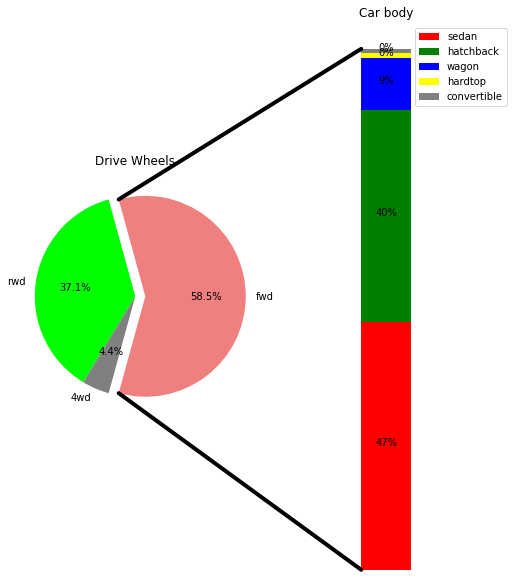

In [4]:
# make figure and assign axis objects
def pie_bar(ratios_pie, labels_pie, ratios_bar, labels_bar_tuple, colors_list, color_bar,bar_title,pie_title):
    fig = plt.figure(figsize=(9, 10.0625))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    fig.subplots_adjust(wspace=0)

    # pie chart parameters
    ratios = ratios_pie
    labels = labels_pie
    explode = [0.1, 0,0]
    # rotate so that first wedge is split by the x-axis
    angle = -180 * ratios[0]
    ax1.pie(ratios, autopct='%1.1f%%', startangle=angle,
            labels=labels, explode=explode, colors = colors_list)
    ax1.set_title(pie_title)
    # bar chart parameters
    xpos = 0
    bottom = 0
    ratios = ratios_bar
    width = .2
    colors = color_bar

    for j in range(len(ratios)):
        height = ratios[j]
        ax2.bar(xpos, height, width, bottom=bottom, color=colors[j])
        ypos = bottom + ax2.patches[j].get_height() / 2
        bottom += height
        ax2.text(xpos, ypos, "%d%%" % (ax2.patches[j].get_height() * 100),
                 ha='center')

    ax2.set_title(bar_title)
    ax2.legend(labels_bar_tuple)
    ax2.axis('off')
    ax2.set_xlim(- 2.5 * width, 2.5 * width)

    # use ConnectionPatch to draw lines between the two plots
    # get the wedge data
    theta1, theta2 = ax1.patches[0].theta1, ax1.patches[0].theta2
    center, r = ax1.patches[0].center, ax1.patches[0].r
    bar_height = sum([item.get_height() for item in ax2.patches])

    # draw top connecting line
    x = r * np.cos(np.pi / 180 * theta2) + center[0]
    y = np.sin(np.pi / 180 * theta2) + center[1]
    con = ConnectionPatch(xyA=(- width / 2, bar_height), xyB=(x, y),
                          coordsA="data", coordsB="data", axesA=ax2, axesB=ax1)
    con.set_color([0, 0, 0])
    con.set_linewidth(4)
    ax2.add_artist(con)

    # draw bottom connecting line
    x = r * np.cos(np.pi / 180 * theta1) + center[0]
    y = np.sin(np.pi / 180 * theta1) + center[1]
    con = ConnectionPatch(xyA=(- width / 2, 0), xyB=(x, y), coordsA="data",
                          coordsB="data", axesA=ax2, axesB=ax1)
    con.set_color([0, 0, 0])
    ax2.add_artist(con)
    con.set_linewidth(4)

    return plt.show()


labels_pie = df.drivewheels.value_counts(normalize=True).index.tolist()
ratios_pie = df.drivewheels.value_counts(normalize=True).tolist()
ratios_bar = df[df.drivewheels =="fwd"].carbody.value_counts(normalize=True).tolist()
labels_bar_tuple = tuple(df[df.drivewheels =="fwd"].carbody.value_counts(normalize=True).index.tolist())
color_bar = ['red', 'green', 'blue', 'yellow', 'grey']
color_pie = ['lightcoral', 'lime','grey']
pie_bar(ratios_pie, labels_pie, ratios_bar, labels_bar_tuple, color_pie, color_bar, "Car body",'Drive Wheels')

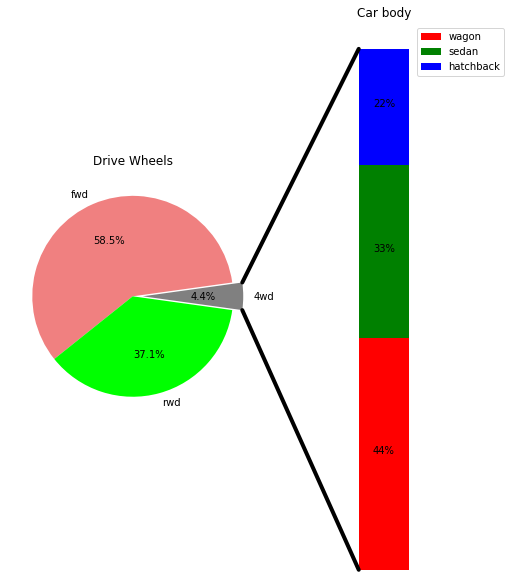

In [5]:
labels_pie = df.drivewheels.value_counts(normalize=True).index.tolist()
labels_pie.insert(0, labels_pie.pop(2))
ratios_pie = df.drivewheels.value_counts(normalize=True).tolist()
ratios_pie.insert(0, ratios_pie.pop(2))
ratios_bar = df[df.drivewheels =="4wd"].carbody.value_counts(normalize=True).tolist()
labels_bar_tuple = tuple(df[df.drivewheels =="4wd"].carbody.value_counts(normalize=True).index.tolist())
color_bar = ['red', 'green', 'blue', 'yellow', 'grey']
color_pie = ['grey', 'lightcoral','lime']
pie_bar(ratios_pie, labels_pie, ratios_bar, labels_bar_tuple, color_pie, color_bar, "Car body",'Drive Wheels')

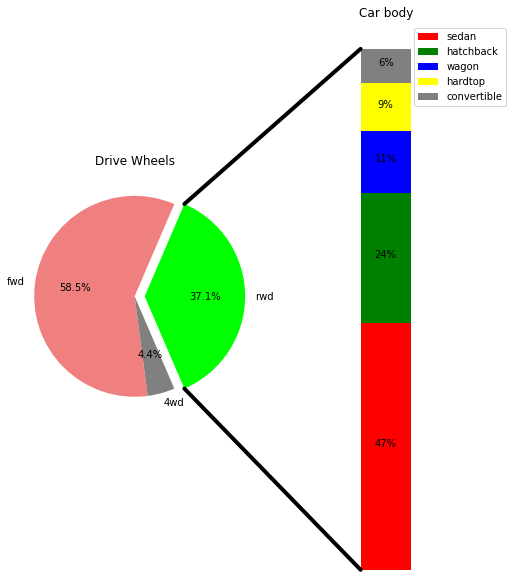

In [6]:
labels_pie = df.drivewheels.value_counts(normalize=True).index.tolist()
labels_pie.insert(0, labels_pie.pop(1))
ratios_pie = df.drivewheels.value_counts(normalize=True).tolist()
ratios_pie.insert(0, ratios_pie.pop(1))
ratios_bar = df[df.drivewheels =="rwd"].carbody.value_counts(normalize=True).tolist()
labels_bar_tuple = tuple(df[df.drivewheels =="rwd"].carbody.value_counts(normalize=True).index.tolist())
color_bar = ['red', 'green', 'blue', 'yellow', 'grey']
color_pie = ['lime', 'lightcoral','grey']
pie_bar(ratios_pie, labels_pie, ratios_bar, labels_bar_tuple, color_pie, color_bar, "Car body",'Drive Wheels')

In [7]:
def get_num_cat_col(df, n):
    numerical_columns = []
    categorical_columns = []
    for col in df.columns:
        len_unique = len(df[col].unique())
        if len_unique <= n:
            categorical_columns.append(col)
        else:
            numerical_columns.append(col)
    return numerical_columns, categorical_columns

numerical_columns, categorical_columns = get_num_cat_col(X, 30)
print(f"categorical = {categorical_columns}")
print()
print(f"numerical = {numerical_columns}")
print()
X[categorical_columns].info()

categorical = ['symboling', 'fueltypes', 'aspiration', 'doornumbers', 'carbody', 'drivewheels', 'enginelocation', 'enginetype', 'cylindernumber', 'fuelsystem', 'peakrpm', 'citympg', 'highwaympg']

numerical = ['wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight', 'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205 entries, 0 to 204
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   symboling       205 non-null    int64 
 1   fueltypes       205 non-null    object
 2   aspiration      205 non-null    object
 3   doornumbers     205 non-null    object
 4   carbody         205 non-null    object
 5   drivewheels     205 non-null    object
 6   enginelocation  205 non-null    object
 7   enginetype      205 non-null    object
 8   cylindernumber  205 non-null    object
 9   fuelsystem      205 non-null    object
 10  peakrpm        

# Modelling Part <a class="anchor" id="0.51"></a>

# Showcase of Preprocessors Param Grid Search <a class="anchor" id="0.5"></a>

Here is showing how we loop the param grid of preprocessing technique, each loop has a unique combination of preprocessing technique. Then we will merge this concept together with the halving grid search with cross valdiation for tuning models' parameter.

In [8]:
tuned_model = None
target_transformers = [TransformedTargetRegressor(regressor=tuned_model, 
                           func=np.log10, 
                           inverse_func=sp.special.exp10),
                       TransformedTargetRegressor(regressor=tuned_model)]

categorical_transformers = [OneHotEncoder(drop="if_binary"), 
                            OrdinalEncoder()]

scaling_transformers = [Normalizer(), 
                        StandardScaler()]

param_grid = {'target_transformers':target_transformers,
              'categorical_transformers':categorical_transformers,
              'scaling_transformers':scaling_transformers}
grid = ParameterGrid(param_grid)

for n, para in enumerate(grid, start=1):
    print(n)
    print(para)
    print()

1
{'categorical_transformers': OneHotEncoder(drop='if_binary'), 'scaling_transformers': Normalizer(), 'target_transformers': TransformedTargetRegressor(func=<ufunc 'log10'>, inverse_func=<ufunc 'exp10'>)}

2
{'categorical_transformers': OneHotEncoder(drop='if_binary'), 'scaling_transformers': Normalizer(), 'target_transformers': TransformedTargetRegressor()}

3
{'categorical_transformers': OneHotEncoder(drop='if_binary'), 'scaling_transformers': StandardScaler(), 'target_transformers': TransformedTargetRegressor(func=<ufunc 'log10'>, inverse_func=<ufunc 'exp10'>)}

4
{'categorical_transformers': OneHotEncoder(drop='if_binary'), 'scaling_transformers': StandardScaler(), 'target_transformers': TransformedTargetRegressor()}

5
{'categorical_transformers': OrdinalEncoder(), 'scaling_transformers': Normalizer(), 'target_transformers': TransformedTargetRegressor(func=<ufunc 'log10'>, inverse_func=<ufunc 'exp10'>)}

6
{'categorical_transformers': OrdinalEncoder(), 'scaling_transformers': Norm

# Define Nested Grid Search Algorithm <a class="anchor" id="0.6"></a>

In [9]:
def assembling_model(categorical_transform, scale_transform,  \
                     X,  y, reg, param_distributions):
        
    preprocessor = make_column_transformer(
        (categorical_transform, categorical_columns),
        (scale_transform, numerical_columns),
    )
    
    x_transform = preprocessor.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(x_transform, y, random_state=42)
    
    search = HalvingGridSearchCV(reg, param_distributions, random_state=42)
    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    best_param = search.best_params_
    return best_model, X_train, X_test, y_train, y_test, best_param

def tuning_whole_algorithm(X,  y, reg, param_distributions, grid):
    result_list = []
    for para in tqdm(grid):
        tuned_model, X_train, X_test, y_train, y_test, parameters = assembling_model(para['categorical_transformers'], para['scaling_transformers'], \
                         X,  y, reg, param_distributions)
        
        para['target_transformers'].regressor = tuned_model
        model = para['target_transformers']
        
        model.fit(X_train, y_train)
        prediction_test = model.predict(X_test)
        model_text_list=[]; metric_list=[]; score_list=[] ; param_list=[] ; preprocessors_list=[]

        # create list of metric to be examined
        metric_functions = [r2_score, r2_score, mean_squared_error,mean_squared_error,mean_absolute_error]
        metric_functions_text = ['R_Squared', 'Adj_R_Squared', 'MSE','RMSE','MAE']

        # for loop of each of the 5 metrics
        for metric_function, metric_function_text in zip(metric_functions, metric_functions_text):
            if metric_function_text == 'Adj_R_Squared':
                Adj_r2 = 1 - (1-r2_score(y_test, prediction_test)) * (len(y)-1)/(len(y)-X.shape[1]-1)
                model_text_list.append(type(model.regressor).__name__); metric_list.append(metric_function_text); score_list.append(Adj_r2); param_list.append(parameters); preprocessors_list.append(para)
            elif metric_function_text == 'RMSE':
                rmse = mean_squared_error(y_test, prediction_test, squared=False)
                model_text_list.append(type(model.regressor).__name__); metric_list.append(metric_function_text); score_list.append(rmse); param_list.append(parameters) ; preprocessors_list.append(para)
            else:
                model_text_list.append(type(model.regressor).__name__); metric_list.append(metric_function_text); score_list.append(metric_function(y_test, prediction_test)); param_list.append(parameters) ; preprocessors_list.append(para)

        d = {'model':model_text_list,'preprocessors':preprocessors_list ,'parameters': param_list ,'metric': metric_list, 'test predict score': score_list}
        df = pd.DataFrame(data=d)
        result_list.append(df)
    df2 = pd.concat(result_list)
    return df2

# Nested Optimisation Search for KNeighborsRegressor <a class="anchor" id="0.7"></a>

In [10]:
reg = KNeighborsRegressor()

param_distributions = {'n_neighbors': [5, 7, 9, 13], 'weights': ['uniform', 'distance']}
df_result_knn = tuning_whole_algorithm(X,  y, reg, param_distributions, grid)
df_result_knn

100%|██████████| 8/8 [00:02<00:00,  3.90it/s]


,model,preprocessors,parameters,metric,test predict score
0,KNeighborsRegressor,"{'categorical_transformers': OneHotEncoder(drop='if_binary'), 'scaling_transformers': Normalizer(), 'target_transformers': TransformedTargetRegressor(func=<ufunc 'log10'>, inverse_func=<ufunc 'exp10'>, regressor=KNeighborsRegressor(n_neighbors=7, weights='distance'))}","{'n_neighbors': 5, 'weights': 'distance'}",R_Squared,8.418155e-01
1,KNeighborsRegressor,"{'categorical_transformers': OneHotEncoder(drop='if_binary'), 'scaling_transformers': Normalizer(), 'target_transformers': TransformedTargetRegressor(func=<ufunc 'log10'>, inverse_func=<ufunc 'exp10'>, regressor=KNeighborsRegressor(n_neighbors=7, weights='distance'))}","{'n_neighbors': 5, 'weights': 'distance'}",Adj_R_Squared,8.217148e-01
2,KNeighborsRegressor,"{'categorical_transformers': OneHotEncoder(drop='if_binary'), 'scaling_transformers': Normalizer(), 'target_transformers': TransformedTargetRegressor(func=<ufunc 'log10'>, inverse_func=<ufunc 'exp10'>, regressor=KNeighborsRegressor(n_neighbors=7, weights='distance'))}","{'n_neighbors': 5, 'weights': 'distance'}",MSE,1.070269e+07
3,KNeighborsRegressor,"{'categorical_transformers': OneHotEncoder(drop='if_binary'), 'scaling_transformers': Normalizer(), 'target_transformers': TransformedTargetRegressor(func=<ufunc 'log10'>, inverse_func=<ufunc 'exp10'>, regressor=KNeighborsRegressor(n_neighbors=7, weights='distance'))}","{'n_neighbors': 5, 'weights': 'distance'}",RMSE,3.271496e+03
4,KNeighborsRegressor,"{'categorical_transformers': OneHotEncoder(drop='if_binary'), 'scaling_transformers': Normalizer(), 'target_transformers': TransformedTargetRegressor(func=<ufunc 'log10'>, inverse_func=<ufunc 'exp10'>, regressor=KNeighborsRegressor(n_neighbors=7, weights='distance'))}","{'n_neighbors': 5, 'weights': 'distance'}",MAE,2.142485e+03
0,KNeighborsRegressor,"{'categorical_transformers': OneHotEncoder(drop='if_binary'), 'scaling_transformers': Normalizer(), 'target_transformers': TransformedTargetRegressor(regressor=KNeighborsRegressor(n_neighbors=7, weights='distance'))}","{'n_neighbors': 5, 'weights': 'distance'}",R_Squared,8.576737e-01
1,KNeighborsRegressor,"{'categorical_transformers': OneHotEncoder(drop='if_binary'), 'scaling_transformers': Normalizer(), 'target_transformers': TransformedTargetRegressor(regressor=KNeighborsRegressor(n_neighbors=7, weights='distance'))}","{'n_neighbors': 5, 'weights': 'distance'}",Adj_R_Squared,8.395881e-01
2,KNeighborsRegressor,"{'categorical_transformers': OneHotEncoder(drop='if_binary'), 'scaling_transformers': Normalizer(), 'target_transformers': TransformedTargetRegressor(regressor=KNeighborsRegressor(n_neighbors=7, weights='distance'))}","{'n_neighbors': 5, 'weights': 'distance'}",MSE,9.629730e+06
3,KNeighborsRegressor,"{'categorical_transformers': OneHotEncoder(drop='if_binary'), 'scaling_transformers': Normalizer(), 'target_transformers': TransformedTargetRegressor(regressor=KNeighborsRegressor(n_neighbors=7, weights='distance'))}","{'n_neighbors': 5, 'weights': 'distance'}",RMSE,3.103181e+03
4,KNeighborsRegressor,"{'categorical_transformers': OneHotEncoder(drop='if_binary'), 'scaling_transformers': Normalizer(), 'target_transformers': TransformedTargetRegressor(regressor=KNeighborsRegressor(n_neighbors=7, weights='distance'))}","{'n_neighbors': 5, 'weights': 'distance'}",MAE,2.064848e+03


# Nested Optimisation Search for DecisionTreeRegressor <a class="anchor" id="0.8"></a>

In [11]:
reg = DecisionTreeRegressor(random_state=42)

param_distributions = {'max_depth': [3, 5, None],
 'min_samples_split': [2, 3, 5]}
df_result_dtr = tuning_whole_algorithm(X,  y, reg, param_distributions, grid)
df_result_dtr

100%|██████████| 8/8 [00:01<00:00,  5.37it/s]


,model,preprocessors,parameters,metric,test predict score
0,DecisionTreeRegressor,"{'categorical_transformers': OneHotEncoder(drop='if_binary'), 'scaling_transformers': Normalizer(), 'target_transformers': TransformedTargetRegressor(func=<ufunc 'log10'>, inverse_func=<ufunc 'exp10'>, regressor=DecisionTreeRegressor(min_samples_split=5, random_state=42))}","{'max_depth': 3, 'min_samples_split': 5}",R_Squared,8.829122e-01
1,DecisionTreeRegressor,"{'categorical_transformers': OneHotEncoder(drop='if_binary'), 'scaling_transformers': Normalizer(), 'target_transformers': TransformedTargetRegressor(func=<ufunc 'log10'>, inverse_func=<ufunc 'exp10'>, regressor=DecisionTreeRegressor(min_samples_split=5, random_state=42))}","{'max_depth': 3, 'min_samples_split': 5}",Adj_R_Squared,8.680337e-01
2,DecisionTreeRegressor,"{'categorical_transformers': OneHotEncoder(drop='if_binary'), 'scaling_transformers': Normalizer(), 'target_transformers': TransformedTargetRegressor(func=<ufunc 'log10'>, inverse_func=<ufunc 'exp10'>, regressor=DecisionTreeRegressor(min_samples_split=5, random_state=42))}","{'max_depth': 3, 'min_samples_split': 5}",MSE,7.922105e+06
3,DecisionTreeRegressor,"{'categorical_transformers': OneHotEncoder(drop='if_binary'), 'scaling_transformers': Normalizer(), 'target_transformers': TransformedTargetRegressor(func=<ufunc 'log10'>, inverse_func=<ufunc 'exp10'>, regressor=DecisionTreeRegressor(min_samples_split=5, random_state=42))}","{'max_depth': 3, 'min_samples_split': 5}",RMSE,2.814624e+03
4,DecisionTreeRegressor,"{'categorical_transformers': OneHotEncoder(drop='if_binary'), 'scaling_transformers': Normalizer(), 'target_transformers': TransformedTargetRegressor(func=<ufunc 'log10'>, inverse_func=<ufunc 'exp10'>, regressor=DecisionTreeRegressor(min_samples_split=5, random_state=42))}","{'max_depth': 3, 'min_samples_split': 5}",MAE,2.048565e+03
0,DecisionTreeRegressor,"{'categorical_transformers': OneHotEncoder(drop='if_binary'), 'scaling_transformers': Normalizer(), 'target_transformers': TransformedTargetRegressor(regressor=DecisionTreeRegressor(min_samples_split=5, random_state=42))}","{'max_depth': 3, 'min_samples_split': 5}",R_Squared,8.106648e-01
1,DecisionTreeRegressor,"{'categorical_transformers': OneHotEncoder(drop='if_binary'), 'scaling_transformers': Normalizer(), 'target_transformers': TransformedTargetRegressor(regressor=DecisionTreeRegressor(min_samples_split=5, random_state=42))}","{'max_depth': 3, 'min_samples_split': 5}",Adj_R_Squared,7.866056e-01
2,DecisionTreeRegressor,"{'categorical_transformers': OneHotEncoder(drop='if_binary'), 'scaling_transformers': Normalizer(), 'target_transformers': TransformedTargetRegressor(regressor=DecisionTreeRegressor(min_samples_split=5, random_state=42))}","{'max_depth': 3, 'min_samples_split': 5}",MSE,1.281033e+07
3,DecisionTreeRegressor,"{'categorical_transformers': OneHotEncoder(drop='if_binary'), 'scaling_transformers': Normalizer(), 'target_transformers': TransformedTargetRegressor(regressor=DecisionTreeRegressor(min_samples_split=5, random_state=42))}","{'max_depth': 3, 'min_samples_split': 5}",RMSE,3.579153e+03
4,DecisionTreeRegressor,"{'categorical_transformers': OneHotEncoder(drop='if_binary'), 'scaling_transformers': Normalizer(), 'target_transformers': TransformedTargetRegressor(regressor=DecisionTreeRegressor(min_samples_split=5, random_state=42))}","{'max_depth': 3, 'min_samples_split': 5}",MAE,2.436078e+03


# Nested Optimisation Search for Random Forest Regressor <a class="anchor" id="0.9"></a>

In [12]:
reg = RandomForestRegressor(random_state=42)
param_distributions = {'max_depth': [3, 5, None],
 'min_samples_split': [2, 3, 5],
 'n_estimators': [100, 300]}
df_result_rfr = tuning_whole_algorithm(X,  y, reg, param_distributions, grid)
df_result_rfr

100%|██████████| 8/8 [05:08<00:00, 38.62s/it]


,model,preprocessors,parameters,metric,test predict score
0,RandomForestRegressor,"{'categorical_transformers': OneHotEncoder(drop='if_binary'), 'scaling_transformers': Normalizer(), 'target_transformers': TransformedTargetRegressor(func=<ufunc 'log10'>, inverse_func=<ufunc 'exp10'>, regressor=RandomForestRegressor(min_samples_split=3, n_estimators=300, random_state=42))}","{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}",R_Squared,9.312506e-01
1,RandomForestRegressor,"{'categorical_transformers': OneHotEncoder(drop='if_binary'), 'scaling_transformers': Normalizer(), 'target_transformers': TransformedTargetRegressor(func=<ufunc 'log10'>, inverse_func=<ufunc 'exp10'>, regressor=RandomForestRegressor(min_samples_split=3, n_estimators=300, random_state=42))}","{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}",Adj_R_Squared,9.225145e-01
2,RandomForestRegressor,"{'categorical_transformers': OneHotEncoder(drop='if_binary'), 'scaling_transformers': Normalizer(), 'target_transformers': TransformedTargetRegressor(func=<ufunc 'log10'>, inverse_func=<ufunc 'exp10'>, regressor=RandomForestRegressor(min_samples_split=3, n_estimators=300, random_state=42))}","{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}",MSE,4.651551e+06
3,RandomForestRegressor,"{'categorical_transformers': OneHotEncoder(drop='if_binary'), 'scaling_transformers': Normalizer(), 'target_transformers': TransformedTargetRegressor(func=<ufunc 'log10'>, inverse_func=<ufunc 'exp10'>, regressor=RandomForestRegressor(min_samples_split=3, n_estimators=300, random_state=42))}","{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}",RMSE,2.156745e+03
4,RandomForestRegressor,"{'categorical_transformers': OneHotEncoder(drop='if_binary'), 'scaling_transformers': Normalizer(), 'target_transformers': TransformedTargetRegressor(func=<ufunc 'log10'>, inverse_func=<ufunc 'exp10'>, regressor=RandomForestRegressor(min_samples_split=3, n_estimators=300, random_state=42))}","{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}",MAE,1.498799e+03
0,RandomForestRegressor,"{'categorical_transformers': OneHotEncoder(drop='if_binary'), 'scaling_transformers': Normalizer(), 'target_transformers': TransformedTargetRegressor(regressor=RandomForestRegressor(min_samples_split=3, n_estimators=300, random_state=42))}","{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}",R_Squared,9.347333e-01
1,RandomForestRegressor,"{'categorical_transformers': OneHotEncoder(drop='if_binary'), 'scaling_transformers': Normalizer(), 'target_transformers': TransformedTargetRegressor(regressor=RandomForestRegressor(min_samples_split=3, n_estimators=300, random_state=42))}","{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}",Adj_R_Squared,9.264398e-01
2,RandomForestRegressor,"{'categorical_transformers': OneHotEncoder(drop='if_binary'), 'scaling_transformers': Normalizer(), 'target_transformers': TransformedTargetRegressor(regressor=RandomForestRegressor(min_samples_split=3, n_estimators=300, random_state=42))}","{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}",MSE,4.415912e+06
3,RandomForestRegressor,"{'categorical_transformers': OneHotEncoder(drop='if_binary'), 'scaling_transformers': Normalizer(), 'target_transformers': TransformedTargetRegressor(regressor=RandomForestRegressor(min_samples_split=3, n_estimators=300, random_state=42))}","{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}",RMSE,2.101407e+03
4,RandomForestRegressor,"{'categorical_transformers': OneHotEncoder(drop='if_binary'), 'scaling_transformers': Normalizer(), 'target_transformers': TransformedTargetRegressor(regressor=RandomForestRegressor(min_samples_split=3, n_estimators=300, random_state=42))}","{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}",MAE,1.498898e+03


# Concatenate Results <a class="anchor" id="1.0"></a>

In [13]:
df_result = pd.concat([df_result_knn, df_result_dtr,df_result_rfr]).reset_index(drop=True)
df_result

,model,preprocessors,parameters,metric,test predict score
0,KNeighborsRegressor,"{'categorical_transformers': OneHotEncoder(drop='if_binary'), 'scaling_transformers': Normalizer(), 'target_transformers': TransformedTargetRegressor(func=<ufunc 'log10'>, inverse_func=<ufunc 'exp10'>, regressor=RandomForestRegressor(min_samples_split=3, n_estimators=300, random_state=42))}","{'n_neighbors': 5, 'weights': 'distance'}",R_Squared,8.418155e-01
1,KNeighborsRegressor,"{'categorical_transformers': OneHotEncoder(drop='if_binary'), 'scaling_transformers': Normalizer(), 'target_transformers': TransformedTargetRegressor(func=<ufunc 'log10'>, inverse_func=<ufunc 'exp10'>, regressor=RandomForestRegressor(min_samples_split=3, n_estimators=300, random_state=42))}","{'n_neighbors': 5, 'weights': 'distance'}",Adj_R_Squared,8.217148e-01
2,KNeighborsRegressor,"{'categorical_transformers': OneHotEncoder(drop='if_binary'), 'scaling_transformers': Normalizer(), 'target_transformers': TransformedTargetRegressor(func=<ufunc 'log10'>, inverse_func=<ufunc 'exp10'>, regressor=RandomForestRegressor(min_samples_split=3, n_estimators=300, random_state=42))}","{'n_neighbors': 5, 'weights': 'distance'}",MSE,1.070269e+07
3,KNeighborsRegressor,"{'categorical_transformers': OneHotEncoder(drop='if_binary'), 'scaling_transformers': Normalizer(), 'target_transformers': TransformedTargetRegressor(func=<ufunc 'log10'>, inverse_func=<ufunc 'exp10'>, regressor=RandomForestRegressor(min_samples_split=3, n_estimators=300, random_state=42))}","{'n_neighbors': 5, 'weights': 'distance'}",RMSE,3.271496e+03
4,KNeighborsRegressor,"{'categorical_transformers': OneHotEncoder(drop='if_binary'), 'scaling_transformers': Normalizer(), 'target_transformers': TransformedTargetRegressor(func=<ufunc 'log10'>, inverse_func=<ufunc 'exp10'>, regressor=RandomForestRegressor(min_samples_split=3, n_estimators=300, random_state=42))}","{'n_neighbors': 5, 'weights': 'distance'}",MAE,2.142485e+03
...,...,...,...,...,...
115,RandomForestRegressor,"{'categorical_transformers': OrdinalEncoder(), 'scaling_transformers': StandardScaler(), 'target_transformers': TransformedTargetRegressor(regressor=RandomForestRegressor(min_samples_split=3, n_estimators=300, random_state=42))}","{'max_depth': None, 'min_samples_split': 3, 'n_estimators': 300}",R_Squared,9.449688e-01
116,RandomForestRegressor,"{'categorical_transformers': OrdinalEncoder(), 'scaling_transformers': StandardScaler(), 'target_transformers': TransformedTargetRegressor(regressor=RandomForestRegressor(min_samples_split=3, n_estimators=300, random_state=42))}","{'max_depth': None, 'min_samples_split': 3, 'n_estimators': 300}",Adj_R_Squared,9.379759e-01
117,RandomForestRegressor,"{'categorical_transformers': OrdinalEncoder(), 'scaling_transformers': StandardScaler(), 'target_transformers': TransformedTargetRegressor(regressor=RandomForestRegressor(min_samples_split=3, n_estimators=300, random_state=42))}","{'max_depth': None, 'min_samples_split': 3, 'n_estimators': 300}",MSE,3.723384e+06
118,RandomForestRegressor,"{'categorical_transformers': OrdinalEncoder(), 'scaling_transformers': StandardScaler(), 'target_transformers': TransformedTargetRegressor(regressor=RandomForestRegressor(min_samples_split=3, n_estimators=300, random_state=42))}","{'max_depth': None, 'min_samples_split': 3, 'n_estimators': 300}",RMSE,1.929607e+03


# Best Model Summary <a class="anchor" id="1.1"></a>

Let's retrieve the best model for each performance metric

In [14]:
print("Best R2")
df_result_t = df_result[df_result.metric== 'R_Squared']
display(df_result_t.loc[df_result_t['test predict score'].idxmax()].to_frame())

print("Best Adj R2")
df_result_t = df_result[df_result.metric== 'Adj_R_Squared']
display(df_result_t.loc[df_result_t['test predict score'].idxmax()].to_frame())

print("Best MSE")
df_result_t = df_result[df_result.metric== 'MSE']
display(df_result_t.loc[df_result_t['test predict score'].idxmin()].to_frame())

print("Best RMSE")
df_result_t = df_result[df_result.metric== 'RMSE']
display(df_result_t.loc[df_result_t['test predict score'].idxmin()].to_frame())

print("Best MAE")
df_result_t = df_result[df_result.metric== 'MAE']
display(df_result_t.loc[df_result_t['test predict score'].idxmin()].to_frame())

Best R2


,115
model,RandomForestRegressor
preprocessors,"{'categorical_transformers': OrdinalEncoder(), 'scaling_transformers': StandardScaler(), 'target_transformers': TransformedTargetRegressor(regressor=RandomForestRegressor(min_samples_split=3, n_estimators=300, random_state=42))}"
parameters,"{'max_depth': None, 'min_samples_split': 3, 'n_estimators': 300}"
metric,R_Squared
test predict score,0.944969


Best Adj R2


,116
model,RandomForestRegressor
preprocessors,"{'categorical_transformers': OrdinalEncoder(), 'scaling_transformers': StandardScaler(), 'target_transformers': TransformedTargetRegressor(regressor=RandomForestRegressor(min_samples_split=3, n_estimators=300, random_state=42))}"
parameters,"{'max_depth': None, 'min_samples_split': 3, 'n_estimators': 300}"
metric,Adj_R_Squared
test predict score,0.937976


Best MSE


,117
model,RandomForestRegressor
preprocessors,"{'categorical_transformers': OrdinalEncoder(), 'scaling_transformers': StandardScaler(), 'target_transformers': TransformedTargetRegressor(regressor=RandomForestRegressor(min_samples_split=3, n_estimators=300, random_state=42))}"
parameters,"{'max_depth': None, 'min_samples_split': 3, 'n_estimators': 300}"
metric,MSE
test predict score,3723383.589883


Best RMSE


,118
model,RandomForestRegressor
preprocessors,"{'categorical_transformers': OrdinalEncoder(), 'scaling_transformers': StandardScaler(), 'target_transformers': TransformedTargetRegressor(regressor=RandomForestRegressor(min_samples_split=3, n_estimators=300, random_state=42))}"
parameters,"{'max_depth': None, 'min_samples_split': 3, 'n_estimators': 300}"
metric,RMSE
test predict score,1929.607108


Best MAE


,119
model,RandomForestRegressor
preprocessors,"{'categorical_transformers': OrdinalEncoder(), 'scaling_transformers': StandardScaler(), 'target_transformers': TransformedTargetRegressor(regressor=RandomForestRegressor(min_samples_split=3, n_estimators=300, random_state=42))}"
parameters,"{'max_depth': None, 'min_samples_split': 3, 'n_estimators': 300}"
metric,MAE
test predict score,1252.657417


We can deduce that the model Random Forest {'max_depth': None, 'min_samples_split': 3, 'n_estimators': 300} with the listed pre-processing technique is the best algorithm for predicting the target price. Since it can generate the best performance for unseen data.

If you find this notebook useful, feel free to upvote and comment. Thank you!